* Датасет: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
* Задача: протестировать различные алгоритмы градиентного бустинга на данном датасете

In [1]:
!pip install xgboost
!pip install lightgbm
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

seed = 42
np.random.seed(seed)

In [3]:
import zipfile
with zipfile.ZipFile('/content/hw_1_dataset_ml_prof.zip') as r:
    r.extractall('/content')

In [4]:
df = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')

df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [5]:
df = df.drop('customerID', axis=1)
df_copy = df.copy()
df_copy['TotalCharges'] = df_copy['TotalCharges'].apply(lambda x: float(x) if x.strip() else 0)

df['gender'] = df['gender'].apply(lambda x: 1 if x == 'Male' else 0)
df['Partner'] = df['Partner'].apply(lambda x: 1 if x == 'Yes' else 0)
df['Dependents'] = df['Dependents'].apply(lambda x: 1 if x == 'Yes' else 0)
df['PhoneService'] = df['PhoneService'].apply(lambda x: 1 if x == 'Yes' else 0)
df['MultipleLines'] = df['MultipleLines'].apply(lambda x: 1 if x == 'Yes' else (0 if x == 'No' else -1))
df['InternetService'] = df['InternetService'].astype('category').cat.codes
df['OnlineSecurity'] = df['OnlineSecurity'].apply(lambda x: 1 if x == 'Yes' else (0 if x == 'No' else -1))
df['OnlineBackup'] = df['OnlineBackup'].apply(lambda x: 1 if x == 'Yes' else (0 if x == 'No' else -1))
df['DeviceProtection'] = df['DeviceProtection'].apply(lambda x: 1 if x == 'Yes' else (0 if x == 'No' else -1))
df['TechSupport'] = df['TechSupport'].apply(lambda x: 1 if x == 'Yes' else (0 if x == 'No' else -1))
df['StreamingTV'] = df['StreamingTV'].apply(lambda x: 1 if x == 'Yes' else (0 if x == 'No' else -1))
df['StreamingMovies'] = df['StreamingMovies'].apply(lambda x: 1 if x == 'Yes' else (0 if x == 'No' else -1))
df['Contract'] = df['Contract'].astype('category').cat.codes
df['PaperlessBilling'] = df['PaperlessBilling'].apply(lambda x: 1 if x == 'Yes' else 0)
df['PaymentMethod'] = df['PaymentMethod'].astype('category').cat.codes
df['TotalCharges'] = df['TotalCharges'].apply(lambda x: float(x) if x.strip() else 0)
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   int64  
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   int64  
 3   Dependents        7043 non-null   int64  
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   int64  
 6   MultipleLines     7043 non-null   int64  
 7   InternetService   7043 non-null   int8   
 8   OnlineSecurity    7043 non-null   int64  
 9   OnlineBackup      7043 non-null   int64  
 10  DeviceProtection  7043 non-null   int64  
 11  TechSupport       7043 non-null   int64  
 12  StreamingTV       7043 non-null   int64  
 13  StreamingMovies   7043 non-null   int64  
 14  Contract          7043 non-null   int8   
 15  PaperlessBilling  7043 non-null   int64  
 16  PaymentMethod     7043 non-null   int8   


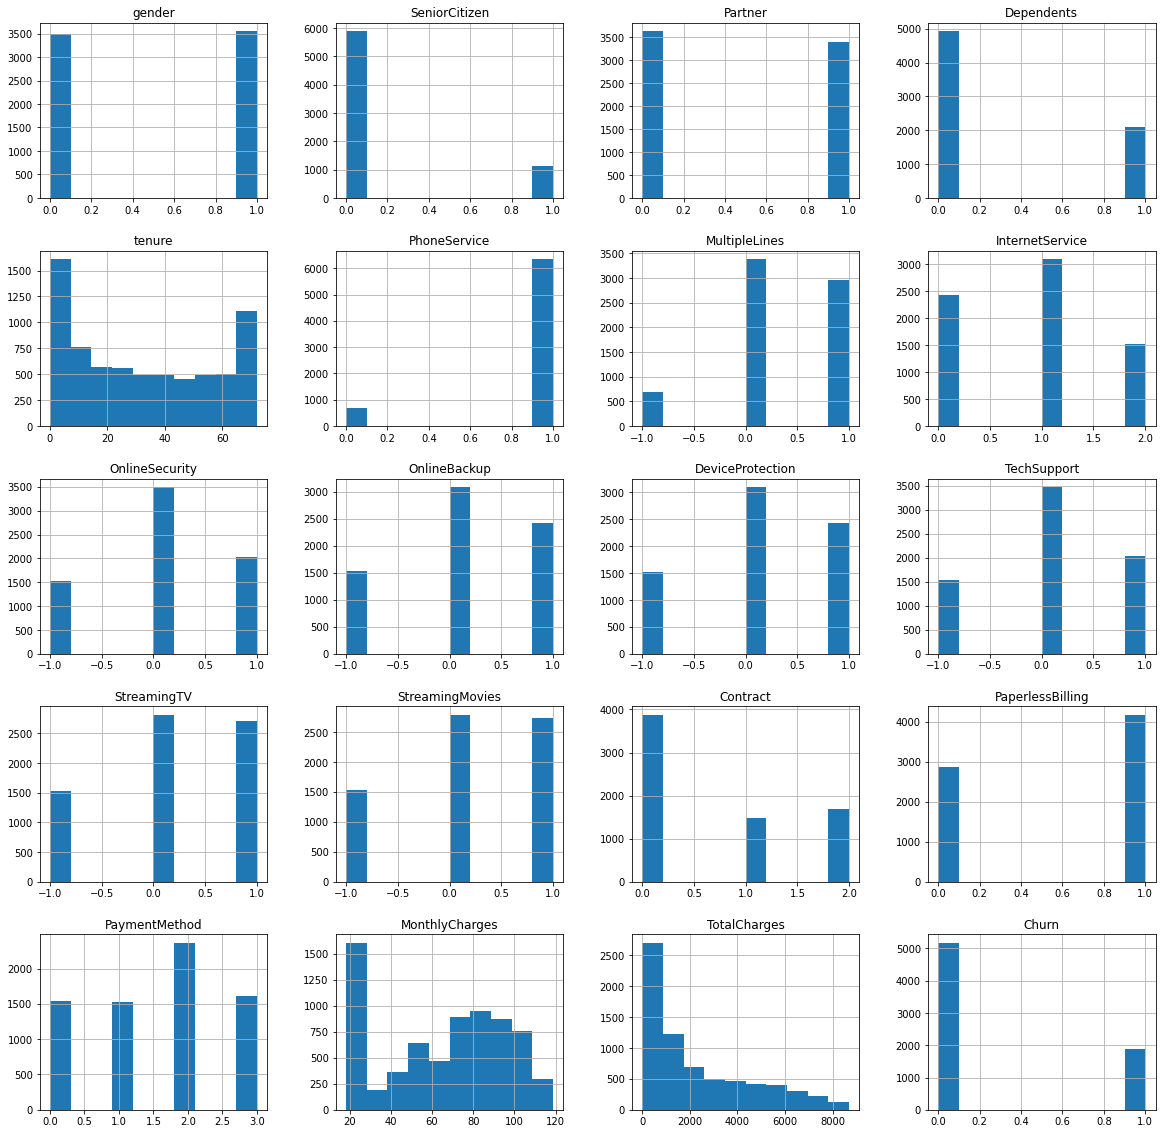

In [7]:
df.hist(figsize=(20, 20));

In [8]:
corr = df.corr()
corr = corr.where(np.tril(np.ones(corr.shape), k=-1).astype(np.bool))

high_corr = [
    column for column in corr.columns if abs(corr[column]['Churn']) > 0.1
]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [9]:
high_corr

['SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges']

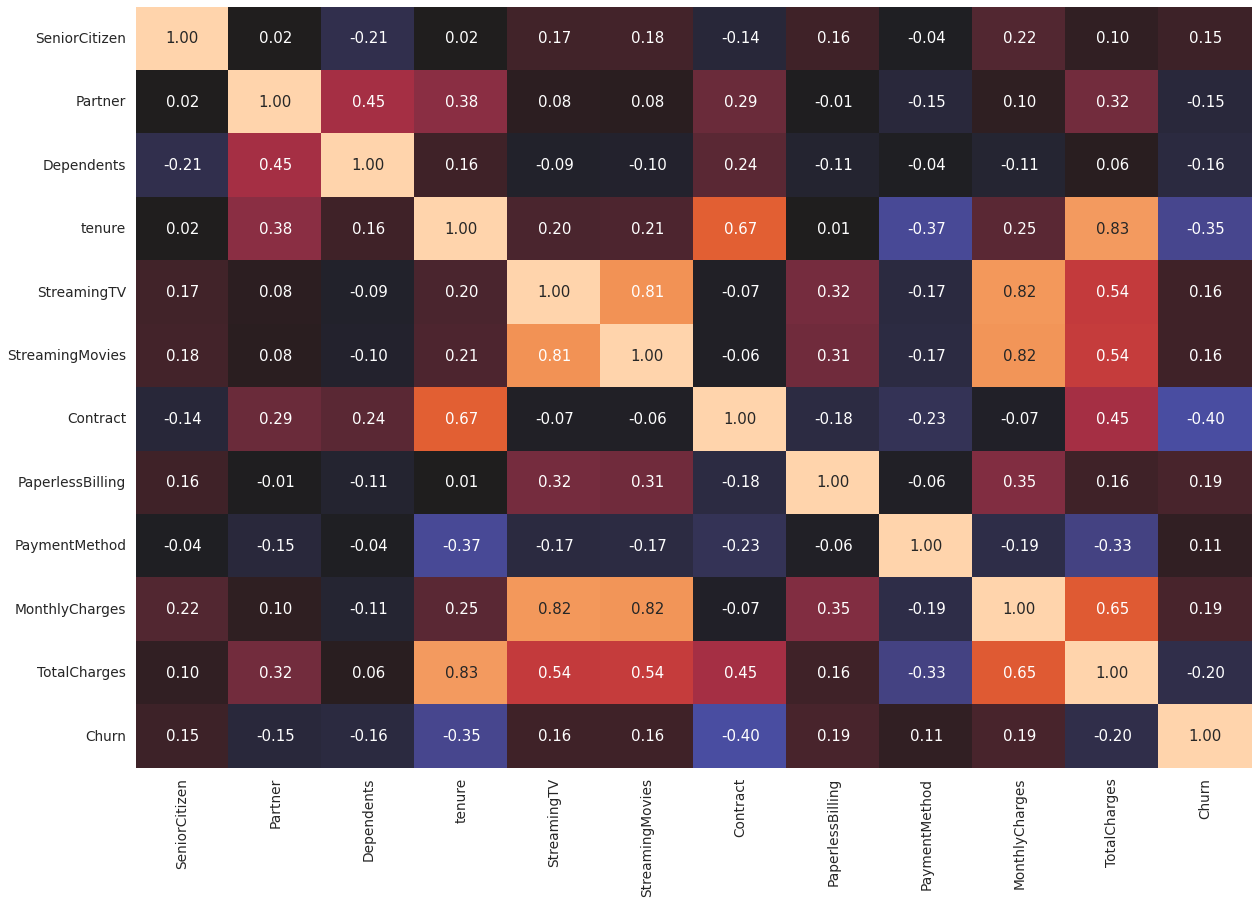

In [10]:
corr = df.drop([col for col in df.columns if col not in high_corr and col != 'Churn'], axis=1).corr()

plt.figure(figsize=(20, 14))
sns.set(font_scale=1.25)
sns.heatmap(corr, annot=True, fmt='.2f', cbar=False, center=0);

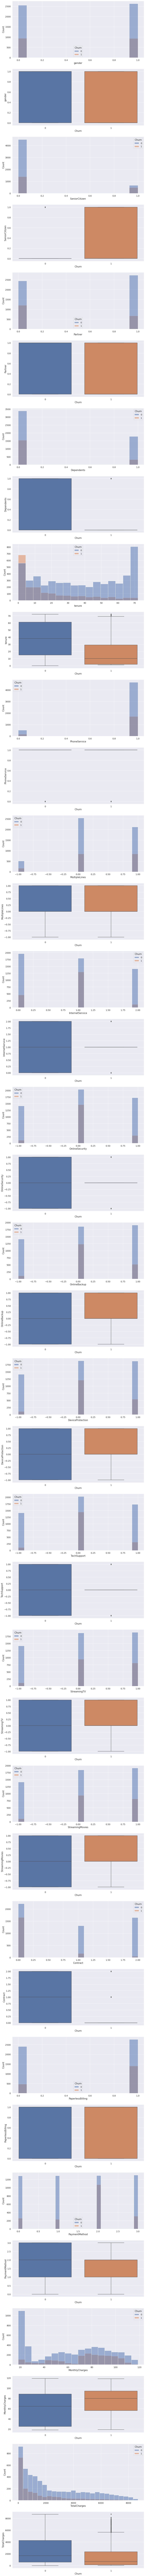

In [11]:
fig, axs = plt.subplots(nrows=(len(df.columns) - 1) * 2)

for index, param in enumerate(df.columns[:-1]):
    fig.set_figheight(150)
    fig.set_figwidth(15)
    sns.histplot(df, x=param, hue='Churn', ax=axs[index * 2])
    fig.set_figheight(300)
    fig.set_figwidth(15)
    sns.boxplot(data=df, x='Churn', y=param, ax=axs[index * 2 + 1])

Для начала попробуем получить результаты на необработанных данных

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgbm
import catboost as cat

In [13]:
def show_metrics(y_test, y_pred, name=''):
    cm = confusion_matrix(y_test, y_pred)
    return f'''
{name}
Accuracy: {accuracy_score(y_test, y_pred)}
ROC-AUC: {roc_auc_score(y_test, y_pred)}
F1-score: {f1_score(y_test, y_pred)}
Precition: {precision_score(y_test, y_pred)}
Recall: {recall_score(y_test, y_pred)}
TN: {cm[0][0]}
FN: {cm[1][0]}
TP: {cm[1][1]}
FP: {cm[0][1]}
Total: {sum(sum(cm))}
'''

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Churn', axis=1), df['Churn'], test_size=0.3, random_state=seed)
X_train_copy, X_test_copy, y_train_copy, y_test_copy = train_test_split(df_copy.drop('Churn', axis=1), df['Churn'], test_size=0.3, random_state=seed)

In [15]:
sklearn_clf = GradientBoostingClassifier(random_state=seed)
xgb_clf = xgb.XGBClassifier(random_state=seed)
lgbm_clf = lgbm.LGBMClassifier(random_state=seed)
cat_clf = cat.CatBoostClassifier(random_state=seed)

sklearn_clf.fit(X_train, y_train)
xgb_clf.fit(X_train, y_train)
lgbm_clf.fit(X_train, y_train)
cat_clf.fit(X_train, y_train, verbose=False)

y_pred_sklearn = sklearn_clf.predict(X_test)
y_pred_xgb = xgb_clf.predict(X_test)
y_pred_lgbm = lgbm_clf.predict(X_test)
y_pred_cat = cat_clf.predict(X_test)

In [16]:
print(show_metrics(y_test, y_pred_sklearn, name='Sklearn Gradient Boosting Classifier Default'))
print(show_metrics(y_test, y_pred_xgb, name='XGB Classifier Default'))
print(show_metrics(y_test, y_pred_lgbm, name='LGBM Classifier Default'))
print(show_metrics(y_test, y_pred_cat, name='CatBoost Classifier Default'))


Sklearn Gradient Boosting Classifier Default
Accuracy: 0.8050165641268339
ROC-AUC: 0.716489733819644
F1-score: 0.5928853754940712
Precition: 0.684931506849315
Recall: 0.5226480836236934
TN: 1401
FN: 274
TP: 300
FP: 138
Total: 2113


XGB Classifier Default
Accuracy: 0.8002839564600095
ROC-AUC: 0.7105099016737869
F1-score: 0.58300395256917
Precition: 0.6735159817351598
Recall: 0.5139372822299652
TN: 1396
FN: 279
TP: 295
FP: 143
Total: 2113


LGBM Classifier Default
Accuracy: 0.7974443918599148
ROC-AUC: 0.7123839408820153
F1-score: 0.5852713178294574
Precition: 0.6593886462882096
Recall: 0.5261324041811847
TN: 1383
FN: 272
TP: 302
FP: 156
Total: 2113


CatBoost Classifier Default
Accuracy: 0.79649787032655
ROC-AUC: 0.7079108113553984
F1-score: 0.5784313725490197
Precition: 0.6614349775784754
Recall: 0.5139372822299652
TN: 1388
FN: 279
TP: 295
FP: 151
Total: 2113



Теперь проведем масштабируем данные и посмотрим на результат

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
sklearn_clf = GradientBoostingClassifier(random_state=seed)
xgb_clf = xgb.XGBClassifier(random_state=seed)
lgbm_clf = lgbm.LGBMClassifier(random_state=seed)
cat_clf = cat.CatBoostClassifier(random_state=seed)

sklearn_clf.fit(X_train, y_train)
xgb_clf.fit(X_train, y_train)
lgbm_clf.fit(X_train, y_train)
cat_clf.fit(X_train, y_train, verbose=False)

y_pred_sklearn = sklearn_clf.predict(X_test)
y_pred_xgb = xgb_clf.predict(X_test)
y_pred_lgbm = lgbm_clf.predict(X_test)
y_pred_cat = cat_clf.predict(X_test)

In [19]:
print(show_metrics(y_test, y_pred_sklearn, name='Sklearn Gradient Boosting'))
print(show_metrics(y_test, y_pred_xgb, name='XGB Classifier'))
print(show_metrics(y_test, y_pred_lgbm, name='LGBM Classifier'))
print(show_metrics(y_test, y_pred_cat, name='CatBoost Classifier'))


Sklearn Gradient Boosting
Accuracy: 0.8054898248935163
ROC-AUC: 0.7173608139590167
F1-score: 0.594274432379072
Precition: 0.6856492027334852
Recall: 0.524390243902439
TN: 1401
FN: 273
TP: 301
FP: 138
Total: 2113


XGB Classifier
Accuracy: 0.8002839564600095
ROC-AUC: 0.7105099016737869
F1-score: 0.58300395256917
Precition: 0.6735159817351598
Recall: 0.5139372822299652
TN: 1396
FN: 279
TP: 295
FP: 143
Total: 2113


LGBM Classifier
Accuracy: 0.7898722195929957
ROC-AUC: 0.7060933725460898
F1-score: 0.574712643678161
Precition: 0.6382978723404256
Recall: 0.5226480836236934
TN: 1369
FN: 274
TP: 300
FP: 170
Total: 2113


CatBoost Classifier
Accuracy: 0.79649787032655
ROC-AUC: 0.7079108113553984
F1-score: 0.5784313725490197
Precition: 0.6614349775784754
Recall: 0.5139372822299652
TN: 1388
FN: 279
TP: 295
FP: 151
Total: 2113



Пока побеждает Sklearn Gradient Boosting

Теперь попробуем подобрать параметры моделей

In [20]:
from sklearn.model_selection import GridSearchCV

In [21]:
sklearn_clf = GradientBoostingClassifier(random_state=seed)
xgb_clf = xgb.XGBClassifier(random_state=seed)
lgbm_clf = lgbm.LGBMClassifier(random_state=seed)
cat_clf = cat.CatBoostClassifier(random_state=seed)

parameters = {
    'n_estimators': [100, 250, 500],
    'max_depth': [1, 3, 5],
    'subsample': [0.25, 0.5, 0.75],
}

gs_sklearn_parameters = parameters.copy()
gs_sklearn_parameters['min_samples_leaf'] = [1, 3, 5]

gs_xgb_parameters = parameters.copy()
gs_xgb_parameters['min_samples_weight'] = [1, 3, 5]

gs_lgbm_parameters = parameters.copy()
gs_lgbm_parameters['min_child_samples'] = [1, 3, 5]

gs_cat_parameters = parameters.copy()
gs_cat_parameters['min_data_in_leaf'] = [1, 3, 5]

gs_sklearn_clf = GridSearchCV(sklearn_clf,
                  gs_sklearn_parameters,
                  scoring='accuracy',
                  cv=3)

gs_xgb_clf = GridSearchCV(xgb_clf,
                  gs_xgb_parameters,
                  scoring='accuracy',
                  cv=3)

gs_lgbm_clf = GridSearchCV(lgbm_clf,
                  gs_lgbm_parameters,
                  scoring='accuracy',
                  cv=3)

gs_cat_clf = GridSearchCV(cat_clf,
                  gs_cat_parameters,
                  scoring='accuracy',
                  cv=3)


%time gs_sklearn_clf.fit(X_train, y_train)
print(gs_sklearn_clf.best_params_)

%time gs_xgb_clf.fit(X_train, y_train)
print(gs_xgb_clf.best_params_)

%time gs_lgbm_clf.fit(X_train, y_train)
print(gs_lgbm_clf.best_params_)

%time gs_cat_clf.fit(X_train, y_train, verbose=False)
print(gs_cat_clf.best_params_)

CPU times: user 3min 21s, sys: 321 ms, total: 3min 21s
Wall time: 3min 22s
{'max_depth': 1, 'min_samples_leaf': 1, 'n_estimators': 250, 'subsample': 0.25}
CPU times: user 2min 10s, sys: 443 ms, total: 2min 10s
Wall time: 2min 10s
{'max_depth': 1, 'min_samples_weight': 1, 'n_estimators': 500, 'subsample': 0.75}
CPU times: user 39.4 s, sys: 903 ms, total: 40.3 s
Wall time: 40.2 s
{'max_depth': 1, 'min_child_samples': 5, 'n_estimators': 500, 'subsample': 0.25}
CPU times: user 1min 35s, sys: 8.49 s, total: 1min 44s
Wall time: 1min
{'max_depth': 3, 'min_data_in_leaf': 1, 'n_estimators': 100, 'subsample': 0.5}


In [22]:
sklearn_clf = GradientBoostingClassifier(random_state=seed, **gs_sklearn_clf.best_params_)
xgb_clf = xgb.XGBClassifier(random_state=seed, **gs_xgb_clf.best_params_)
lgbm_clf = lgbm.LGBMClassifier(random_state=seed, **gs_lgbm_clf.best_params_)
cat_clf = cat.CatBoostClassifier(random_state=seed, **gs_cat_clf.best_params_)

sklearn_clf.fit(X_train, y_train)
xgb_clf.fit(X_train, y_train)
lgbm_clf.fit(X_train, y_train)
cat_clf.fit(X_train, y_train, verbose=False)

y_pred_sklearn = sklearn_clf.predict(X_test)
y_pred_xgb = xgb_clf.predict(X_test)
y_pred_lgbm = lgbm_clf.predict(X_test)
y_pred_cat = cat_clf.predict(X_test)

In [23]:
print(show_metrics(y_test, y_pred_sklearn, name='Sklearn Gradient Boosting with the usage of Grid Search'))
print(show_metrics(y_test, y_pred_xgb, name='XGB Classifier with the usage of Grid Search'))
print(show_metrics(y_test, y_pred_lgbm, name='LGBM Classifier with the usage of Grid Search'))
print(show_metrics(y_test, y_pred_cat, name='CatBoost Classifier with the usage of Grid Search'))


Sklearn Gradient Boosting with the usage of Grid Search
Accuracy: 0.8097491717936584
ROC-AUC: 0.7241081475142237
F1-score: 0.6051080550098232
Precition: 0.6936936936936937
Recall: 0.5365853658536586
TN: 1403
FN: 266
TP: 308
FP: 136
Total: 2113


XGB Classifier with the usage of Grid Search
Accuracy: 0.8035967818267865
ROC-AUC: 0.7166074626493967
F1-score: 0.592737978410206
Precition: 0.6786516853932584
Recall: 0.5261324041811847
TN: 1396
FN: 272
TP: 302
FP: 143
Total: 2113


LGBM Classifier with the usage of Grid Search
Accuracy: 0.8017037387600567
ROC-AUC: 0.7125769482423313
F1-score: 0.5863770977295163
Precition: 0.6765375854214123
Recall: 0.5174216027874564
TN: 1397
FN: 277
TP: 297
FP: 142
Total: 2113


CatBoost Classifier with the usage of Grid Search
Accuracy: 0.8059630856601988
ROC-AUC: 0.7160471187000926
F1-score: 0.592445328031809
Precition: 0.6898148148148148
Recall: 0.519163763066202
TN: 1405
FN: 276
TP: 298
FP: 134
Total: 2113



Посмотрим на важность признаков

In [24]:
sklearn_feature_importances = sklearn_clf.feature_importances_ * 100
xgb_feature_importances = xgb_clf.feature_importances_ * 100
lgbm_feature_importances = lgbm_clf.feature_importances_ / sum(lgbm_clf.feature_importances_) * 100
cat_feature_importances = cat_clf.feature_importances_

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


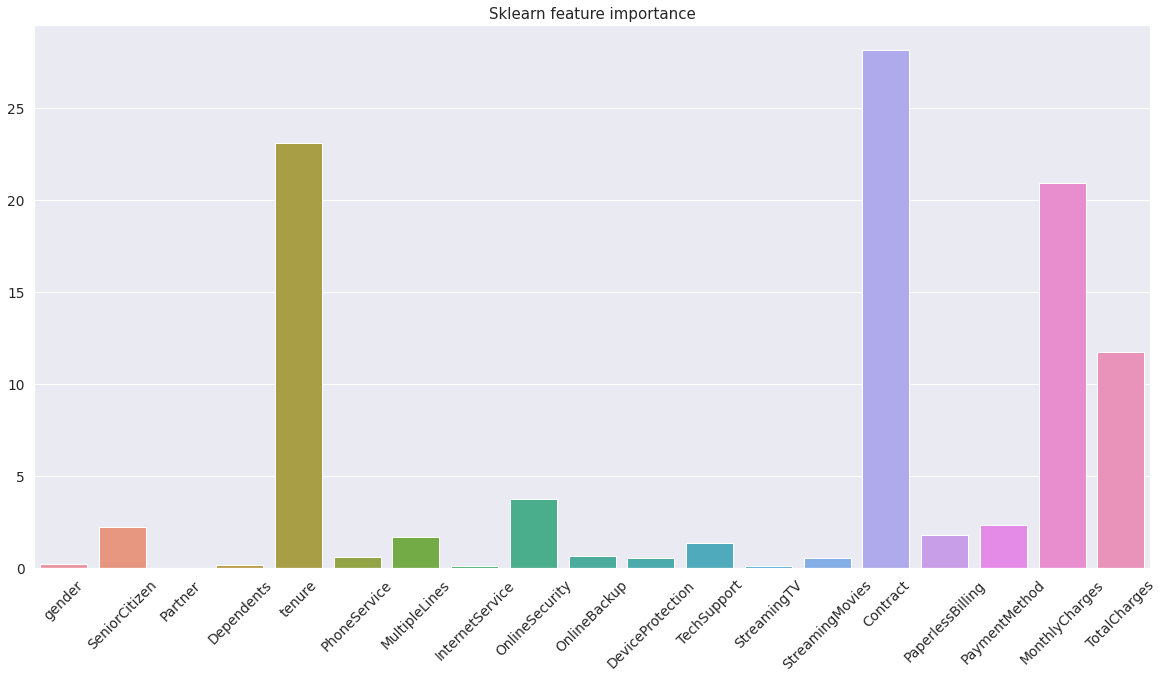

In [25]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)
sns.set(font_scale=1.25)
sns.barplot(df.drop('Churn', axis=1).columns, sklearn_feature_importances).set_title('Sklearn feature importance');

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


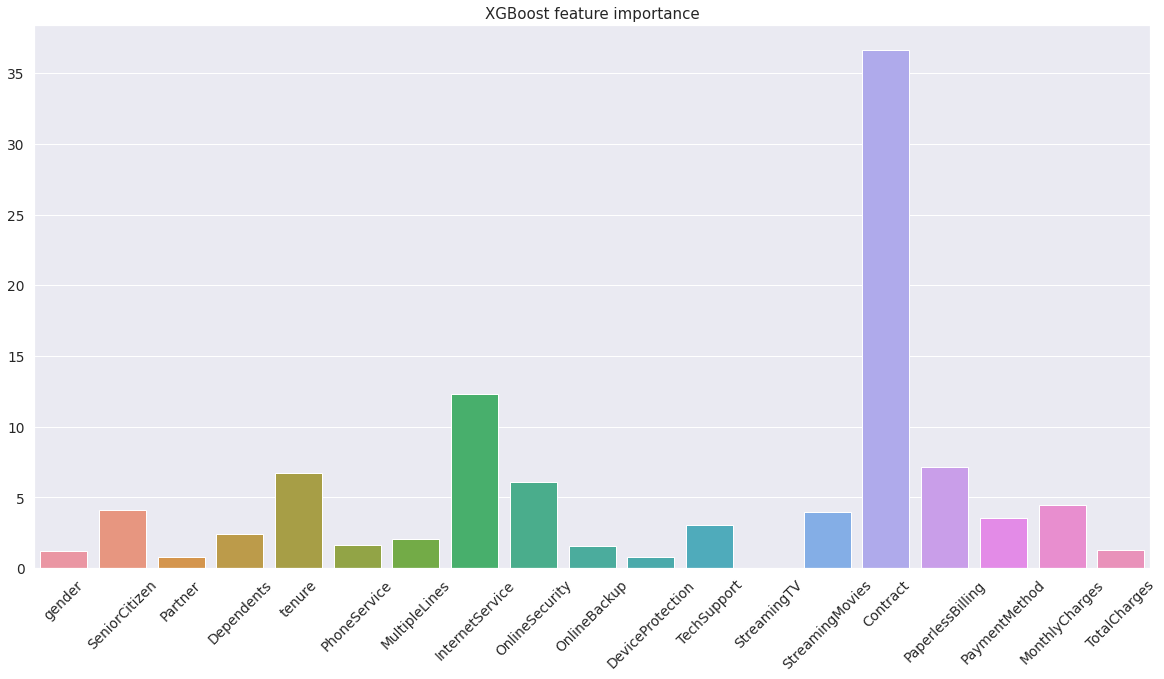

In [26]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)
sns.set(font_scale=1.25)
sns.barplot(df.drop('Churn', axis=1).columns, xgb_feature_importances).set_title('XGBoost feature importance');

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


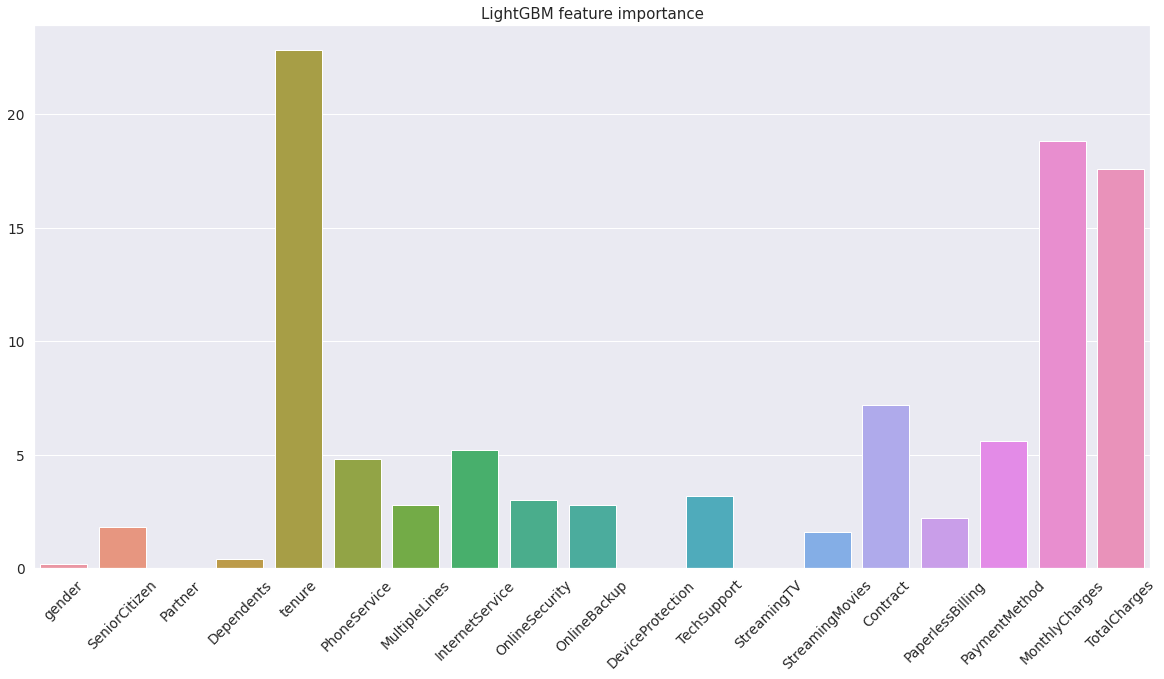

In [27]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)
sns.set(font_scale=1.25)
sns.barplot(df.drop('Churn', axis=1).columns, lgbm_feature_importances).set_title('LightGBM feature importance');

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


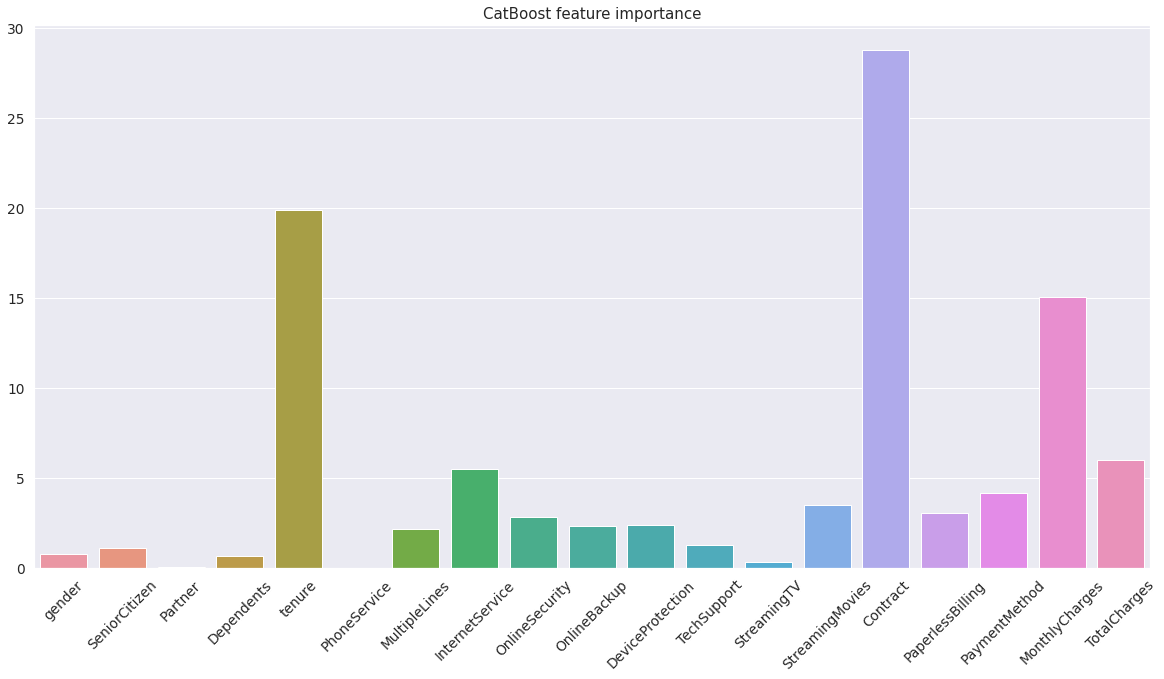

In [28]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)
sns.set(font_scale=1.25)
sns.barplot(df.drop('Churn', axis=1).columns, cat_feature_importances).set_title('CatBoost feature importance');

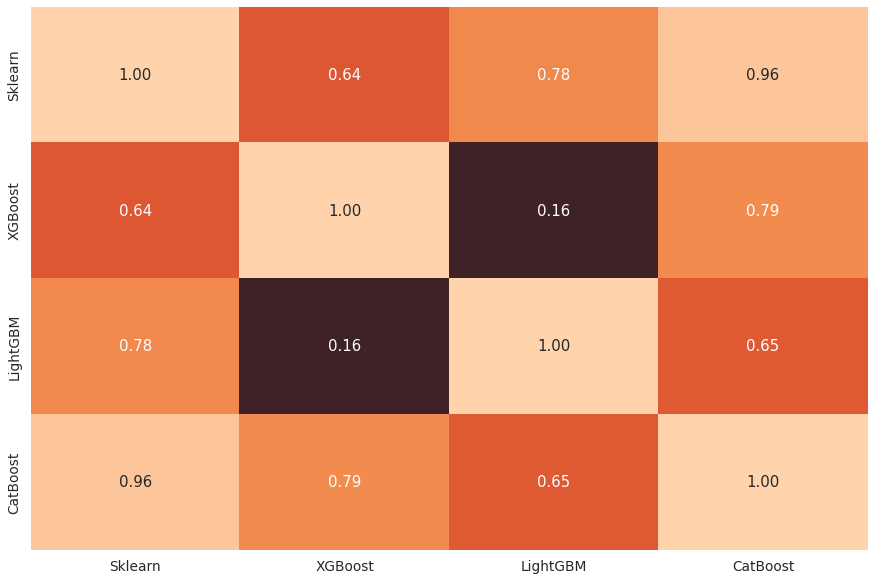

In [29]:
fi_corr = pd.DataFrame(
    index=df.columns[:-1],
    data={'Sklearn': sklearn_feature_importances, 'XGBoost': xgb_feature_importances, 'LightGBM': lgbm_feature_importances, 'CatBoost': cat_feature_importances}
).corr()

plt.figure(figsize=(15, 10))
sns.set(font_scale=1.25)
sns.heatmap(fi_corr, annot=True, fmt='.2f', cbar=False, center=0);

Как видно, важность признаков XGB Classifier и LGBM Classifier коррелирует несильно, поэтому можно попробовать составить несложный ансамбль из этих моделей, а также из всех вместе

In [30]:
print(show_metrics(y_test, list(map(lambda x, y: 0 if not x + y else 1, y_pred_xgb, y_pred_lgbm)), name='XGB Classifier + LGBM Classifier'))
print(
    show_metrics(
        y_test, list(map(lambda w, x, y, z: 0 if w + x + y + z <= 0 else 1, y_pred_sklearn, y_pred_xgb, y_pred_lgbm, y_pred_cat)),
        name='Sklearn Gradient Boosting + XGB Classifier + LGBM Classifier + CatBoost Classifier. 0 threshold <= 0'
    )
)
print(
    show_metrics(
        y_test, list(map(lambda w, x, y, z: 0 if w + x + y + z <= 1 else 1, y_pred_sklearn, y_pred_xgb, y_pred_lgbm, y_pred_cat)),
        name='Sklearn Gradient Boosting + XGB Classifier + LGBM Classifier + CatBoost Classifier. 0 threshold <= 1'
    )
)
print(
    show_metrics(
        y_test, list(map(lambda w, x, y, z: 0 if w + x + y + z <= 2 else 1, y_pred_sklearn, y_pred_xgb, y_pred_lgbm, y_pred_cat)),
        name='Sklearn Gradient Boosting + XGB Classifier + LGBM Classifier + CatBoost Classifier. 0 threshold <= 2'
    )
)
print(
    show_metrics(
        y_test, list(map(lambda w, x, y, z: 0 if w + x + y + z <= 3 else 1, y_pred_sklearn, y_pred_xgb, y_pred_lgbm, y_pred_cat)),
        name='Sklearn Gradient Boosting + XGB Classifier + LGBM Classifier + CatBoost Classifier. 0 threshold <= 3'
    )
)


XGB Classifier + LGBM Classifier
Accuracy: 0.8026502602934217
ROC-AUC: 0.7175962716185224
F1-score: 0.5939629990262901
Precition: 0.673289183222958
Recall: 0.5313588850174216
TN: 1391
FN: 269
TP: 305
FP: 148
Total: 2113


Sklearn Gradient Boosting + XGB Classifier + LGBM Classifier + CatBoost Classifier. 0 threshold <= 0
Accuracy: 0.8069096071935636
ROC-AUC: 0.7330827067669173
F1-score: 0.6165413533834586
Precition: 0.6693877551020408
Recall: 0.5714285714285714
TN: 1377
FN: 246
TP: 328
FP: 162
Total: 2113


Sklearn Gradient Boosting + XGB Classifier + LGBM Classifier + CatBoost Classifier. 0 threshold <= 1
Accuracy: 0.8054898248935163
ROC-AUC: 0.7217303647556108
F1-score: 0.6005830903790087
Precition: 0.6791208791208792
Recall: 0.5383275261324042
TN: 1393
FN: 265
TP: 309
FP: 146
Total: 2113


Sklearn Gradient Boosting + XGB Classifier + LGBM Classifier + CatBoost Classifier. 0 threshold <= 2
Accuracy: 0.804070042593469
ROC-AUC: 0.7120166042930272
F1-score: 0.586
Precition: 0.687793427

У ансамбля из всех моделей с 0 threshold <= 0 наилучший F1

Общий итог: с небольшим отрывом на данной задаче победил бустинг от Sklearn, однако он значительно дольше обучается (это особенно видно при использовании Grid Search), поэтому имеет смысл делать ансамбль из более быстрых алгоритмов, что даст лучший результат и более высокую скорость